In [1]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import pandas as pd

# Get Data

In [2]:
# Get Data
train_val = pd.read_pickle('./TrainValSets2.pkl')
X_all = train_val.drop(['is_goal'], axis=1)
y_all = train_val['is_goal']

# Split into train val
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

# Create dataloaders for NN
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

___

# Neural Network

In [ ]:
from ift6758.training import Net

nn_configs = {
    'small_nn_1': [32, 16],
    'small_nn_2': [64],
    'small_nn_3': [64, 64],
    'small_nn_4': [256, 128],
    'deeper_nn_1': [256, 128, 64, 64, 32],
    'deeper_nn_2': [512, 256, 128, 64, 32, 16],
    }

In [ ]:
import os

models_dict = {}
model_files_dir = '../../train/custom_nn_models/'

for model_name, hidden_layers in nn_configs.items():
    model = Net(X_train.shape[1], hidden_layers, 1)
    model.load_state_dict(torch.load(os.path.join(model_files_dir, model_name, 'model.pt')))

    outputs = model(X_val_tensor.to(model.device))
    prob = outputs.cpu().detach().numpy()[:, 0]
    
    models_dict[model_name] = prob

### Plots

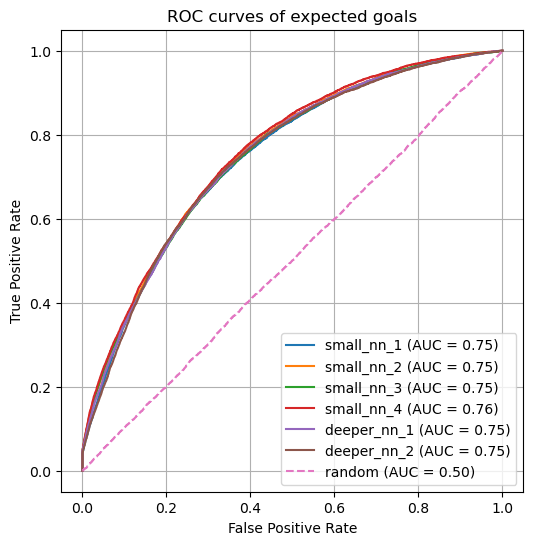

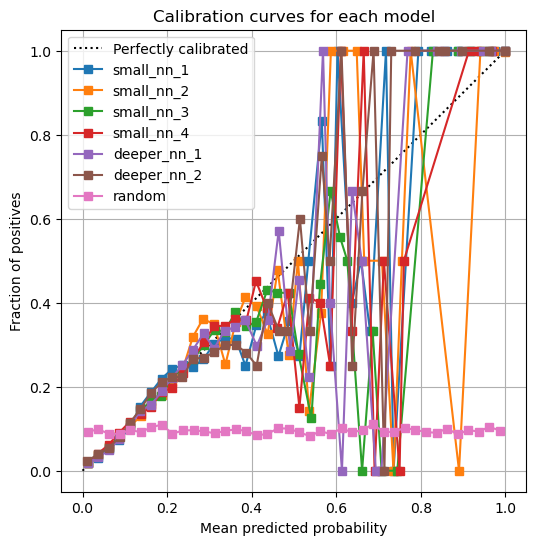

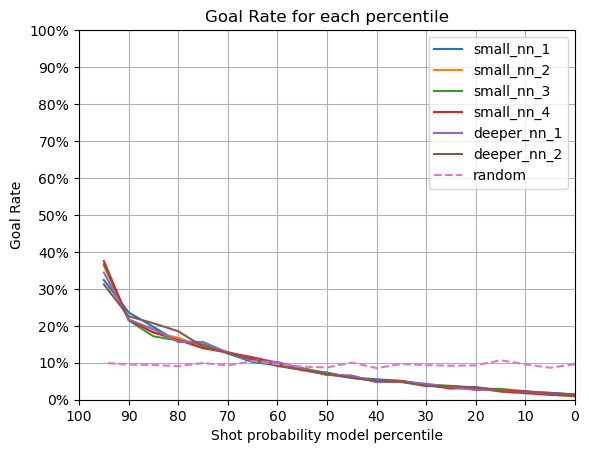

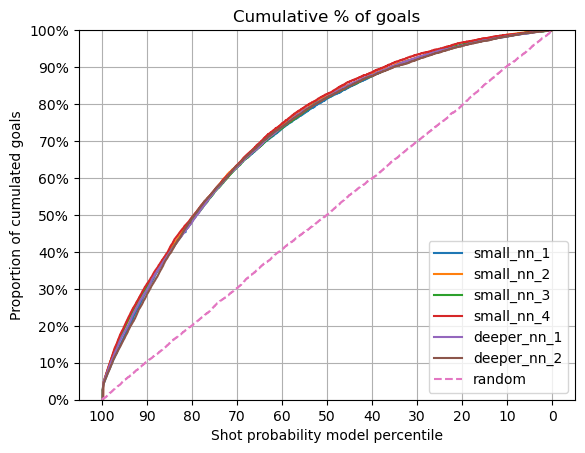

In [ ]:
from ift6758.training.plot import plot_all

plot_all(models_dict, y_val)

------

# Random Forest

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from ift6758.training import BasicModel
from sklearn.metrics import classification_report

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

model = BasicModel(rf_classifier)
model.train(X_train, y_train)

y_pred, accuracy = model.evaluate(X_val, y_val)
print(f"Accuracy: {accuracy:.4f}")

probabilities = model.get_pred_proba(X_val)

# model.save("random_forest_model.pkl")

print(classification_report(y_val, y_pred))

Accuracy: 0.9090
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     80946
           1       0.72      0.06      0.12      8478

    accuracy                           0.91     89424
   macro avg       0.82      0.53      0.54     89424
weighted avg       0.89      0.91      0.87     89424



In [ ]:
# Log to comet
from comet_ml import Experiment
import os

experiment = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    workspace='ift6758-a5-nhl',
    project_name='milestone2',
)
experiment.set_name("random_forest")

experiment.log_parameters({
    "model": "Random Forest",
    "accuracy": accuracy,
    "n_estimators": 100,
    "random_state": 42
})

experiment.log_metric("accuracy", accuracy)

experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-a5-nhl/milestone2/5d2695bd91e34bf49069aa563b16bad3

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a5-nhl/milestone2/5d2695bd91e34bf49069aa563b16bad3
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.9089506172839507
COMET INFO:   Others:
COMET INFO:     Name : random_forest
COMET INFO:   Parameters:
COMET INF

In [ ]:
importances = rf_classifier.feature_importances_

feature_names = X_train.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=["importance"]).sort_values("importance", ascending=False)

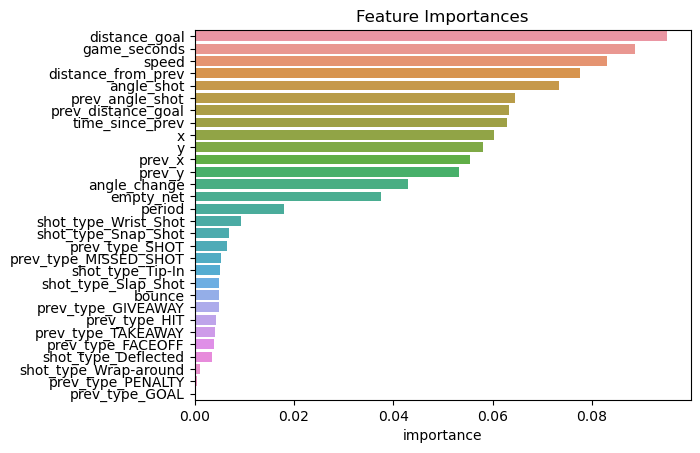

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x="importance", y=feature_importances.index, data=feature_importances)
plt.title("Feature Importances")
plt.show()

In [ ]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(rf_classifier, random_state=42).fit(X_val, y_val)

eli5.show_weights(perm, feature_names = X_val.columns.tolist())

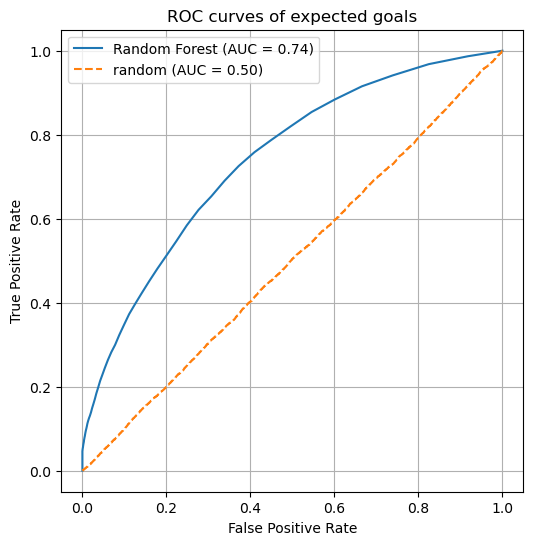

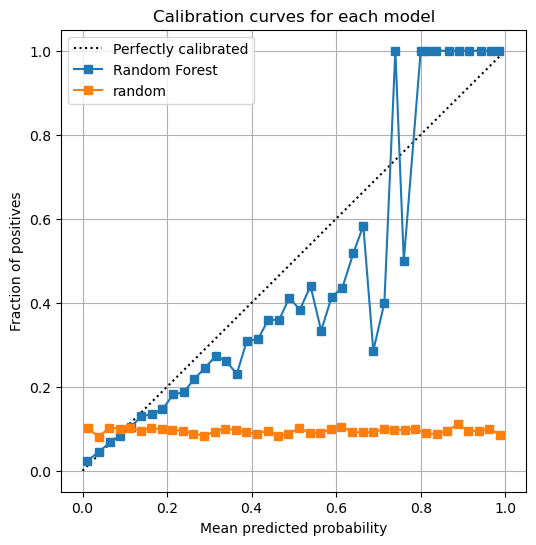

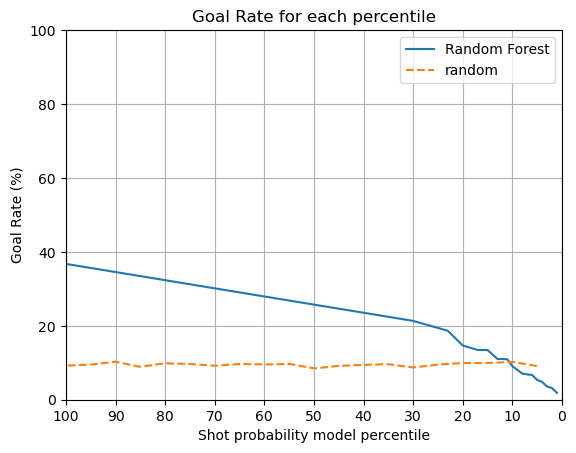

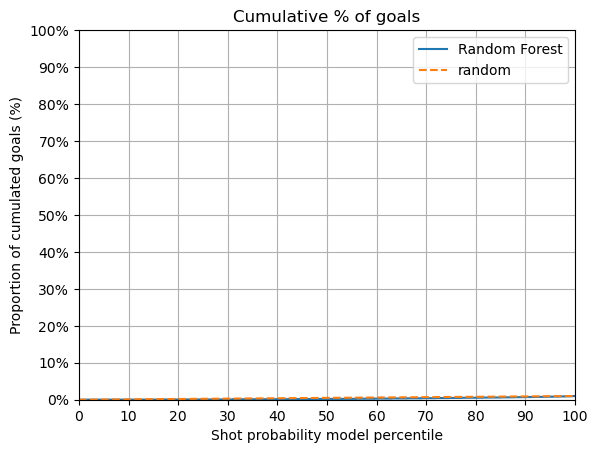

In [4]:
models_dict = {
    'Random Forest': probabilities
}

from ift6758.training.plot import plot_all_random_forest

plot_all_random_forest(models_dict, y_val)

# Data sets division

In [ ]:
from ift6758.features import FeatureEng
data_path_clean = './../../ift6758/data/json_clean/'
w = FeatureEng(data_path_clean)

In [ ]:
df = w.features_2(2016,2020, drop_teams=False)
df.shape

(298079, 21)

### Removing first games for each team

In [ ]:
team_games = w.get_team_games_seasons(2016, 2020)

w.remove_first_team_games(df, team_games, num_regular=5)

train_df = df.drop(columns=['game_id', 'team'])
drop
categorical_features = ['shot_type', 'prev_type']
train_df = w.encodeCategories(train_df, categorical_features)

In [ ]:
from sklearn.model_selection import train_test_split

X = train_df.drop(['is_goal'], axis=1)
y = train_df['is_goal']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from ift6758.training import BasicModel
from sklearn.metrics import classification_report

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

model = BasicModel(rf_classifier)
model.train(X_train, y_train)

y_pred, accuracy = model.evaluate(X_val, y_val)
print(f"Accuracy: {accuracy:.4f}")

probabilities = model.get_pred_proba(X_train)

# model.save("random_forest_model.pkl")

print(classification_report(y_val, y_pred))


In [ ]:
# Log to comet
from comet_ml import Experiment
import os

experiment = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    workspace='ift6758-a5-nhl',
    project_name='milestone2',
)
experiment.set_name("random_forest_first_games_removed")

experiment.log_parameters({
    "model": "Random Forest first 5 season games removed for each team",
    "accuracy": accuracy,
    "n_estimators": 100,
    "random_state": 42
})

experiment.log_metric("accuracy", accuracy)

experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-a5-nhl/milestone2/4df7a325d22c4bdcb4c9af0a1af0e22e

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a5-nhl/milestone2/4df7a325d22c4bdcb4c9af0a1af0e22e
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.9103611632831285
COMET INFO:   Others:
COMET INFO:     Name : random_forest_first_games_removed
COMET INFO:   P

# Splitting the data sets by season and not randomizing on a small NN

In [ ]:
from comet_ml import Experiment
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score
import torch
import torch.nn as nn
import os
from ift6758.training.net_model import Net
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [ ]:
from ift6758.features import FeatureEng
data_path_clean = './../../ift6758/data/json_clean/'
w = FeatureEng(data_path_clean)

df = w.features_2(2016,2020)

df['season'] = df['game_id'].astype(str).str[:4].astype(int)

train_seasons = [2016, 2017, 2018]
val_seasons = [2019]

train_df = df[df['season'].isin(train_seasons)]
val_df = df[df['season'].isin(val_seasons)]

train_df = train_df.drop(columns=['game_id', 'season'])
val_df = val_df.drop(columns=['game_id', 'season'])

categorical_features = ['shot_type', 'prev_type']
train_df = w.encodeCategories(train_df, categorical_features)
val_df = w.encodeCategories(val_df, categorical_features)

-----

## (Can ignore copied mess of script for NN training)

In [ ]:
X_train = train_df.drop(['is_goal'], axis=1)
y_train = train_df['is_goal']

X_val = val_df.drop(['is_goal'], axis=1)
y_val = val_df['is_goal']

# Create dataloaders for NN
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Create TensorDatasets for training and testing data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
nn_epochs = 15
nn_lr = 0.001
models_dict = {}

workspace = 'ift6758-a5-nhl'
project_name = 'milestone2'

def train_mlp(num_epochs, model, criterion, optimizer, train_loader, val_loader):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            X = X.to(model.device)
            y = y.to(model.device)

            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        print(f'Epoch: {epoch + 1} \tTraining Loss: {train_loss:.6f}')
        val_loss, probabilities = val_mlp(model, criterion, val_loader)
        val_losses.append(val_loss)

    return train_losses, val_losses, probabilities

def val_mlp(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    probabilities = []

    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(model.device)
            y = y.to(model.device)

            outputs = model(X)
            loss = criterion(outputs, y.unsqueeze(1))

            val_loss += loss.item() * X.size(0)
            probabilities.extend(outputs.cpu().numpy()[:, 0])
            

    val_loss /= len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.6f}')

    return val_loss, probabilities

def run_nn_config(model_name, hidden_layers, input_shape, train_loader, val_loader, y_val, exp_folder):
    print(f'------ Training nn model: {model_name} ------')
    # Setup Experiment
    exp = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),
        workspace=workspace,
        project_name=project_name
    )
    exp.set_name(model_name)
    tags = ['CustomModels', 'NeuralNetwork', model_name,  'AllFeatures']
    exp.add_tags(tags)

    # Train model
    model = Net(input_shape, hidden_layers, 1)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=nn_lr)
    train_losses, val_losses, probabilities = train_mlp(nn_epochs, model, criterion, optimizer, train_loader, val_loader)
    models_dict[model_name] = probabilities 

    # Log to comet
    thresholds = np.arange(0.0, 1.0, 0.1)
    f1_scores = []; recall_scores = []; accuracy_scores = []
    for threshold in thresholds:
        prob_thresh = [1 if value > threshold else 0 for value in probabilities]
        f1_scores.append(f1_score(y_val, prob_thresh))
        recall_scores.append(recall_score(y_val, prob_thresh))
        accuracy_scores.append(accuracy_score(y_val, prob_thresh))
    
    for epoch in range(nn_epochs):
        exp.log_metric('Training loss', train_losses[epoch], step=epoch)
        exp.log_metric('Validation loss', val_losses[epoch], step=epoch)

    exp.log_curve('F1 score over different thresholds', x=thresholds, y=f1_scores)
    exp.log_curve('Recall score over different thresholds', x=thresholds, y=recall_scores)
    exp.log_curve('Accuracy score over different thresholds', x=thresholds, y=accuracy_scores)
    
    model_folder = os.path.join(exp_folder, model_name)
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)

    model_path = os.path.join(model_folder, 'model.pt')
    torch.save(model.state_dict(), model_path)
    exp.log_model('Model', model_path)
    id = np.argmax(f1_scores)
    exp.log_metric('Accuracy', accuracy_scores[id])
    exp.log_metric('Recall', recall_scores[id])
    exp.log_metric('F1 score', f1_scores[id])

    exp.end()

### (end of ignoring)
_____

In [ ]:
models_folder = './train'
model_name = "small_nn_3_not_randomized_inputs_NN"
layers = [64,64]
run_nn_config(model_name, layers, X_train.shape[1], train_loader, val_loader, y_val, models_folder)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


------ Training nn model: small_nn_3_not_randomized_inputs_NN ------


COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-a5-nhl/milestone2/560dbd772aba4b98ad17f7be1094a49e



Epoch: 1 	Training Loss: 0.310946
Validation Loss: 0.276354
Epoch: 2 	Training Loss: 0.283837
Validation Loss: 0.274065
Epoch: 3 	Training Loss: 0.280623
Validation Loss: 0.273362
Epoch: 4 	Training Loss: 0.278138
Validation Loss: 0.273556
Epoch: 5 	Training Loss: 0.276862
Validation Loss: 0.273140
Epoch: 6 	Training Loss: 0.276045
Validation Loss: 0.273016
Epoch: 7 	Training Loss: 0.275366
Validation Loss: 0.272560
Epoch: 8 	Training Loss: 0.274589
Validation Loss: 0.272035
Epoch: 9 	Training Loss: 0.273955
Validation Loss: 0.271861
Epoch: 10 	Training Loss: 0.273442
Validation Loss: 0.271700
Epoch: 11 	Training Loss: 0.273173
Validation Loss: 0.271440
Epoch: 12 	Training Loss: 0.272889
Validation Loss: 0.271512
Epoch: 13 	Training Loss: 0.272300
Validation Loss: 0.271309
Epoch: 14 	Training Loss: 0.271998
Validation Loss: 0.271164
Epoch: 15 	Training Loss: 0.272011
Validation Loss: 0.271436


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-a5-nhl/milestone2/560dbd772aba4b98ad17f7be1094a49e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy             : 0.7009358531709976
COMET INFO:     F1 score             : 0.30795108105266844
COMET INFO:     Recall               : 0.68688447709864
COMET INFO:     Training loss [15]   : (0.2719975642632189, 0.3109464650965578)
COMET INFO:     Validation loss [15] : (0.27116367024651544, 0.2763543654538073)
COMET INFO:   Others:
COMET INFO:     Name : small_nn_3_not_randomized_inputs_NN
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1